# Introduction

In this notebook, we're going to create lists of terms for mental functions for each construct and domain in the [RDoC](https://www.nimh.nih.gov/research-priorities/rdoc/constructs/rdoc-matrix.shtml) framework. Terms were scraped from RDoC version 5 on January 24, 2019. The overall NLP scheme is as follows:

1. Compute the centroid of terms for mental functions for each construct/domain in semantic space.
2. Identify the most semantically similar terms to each construct/domain centroid across list lengths.
3. Select the word list length that maximizes semantic similarity to the construct/domain centroid.

Our vector space model for semantic content is [GloVe](https://github.com/stanfordnlp/GloVe), which was trained on 42,000 psychiatric neuroimaging articles. The parameters for the GloVe model were a minimum word count of 5, window size of 15, and embedding dimension of 100 over 500 iterations.

# Load the data

In [1]:
import pandas as pd
import warnings
from sklearn.preprocessing import binarize
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
vsm = pd.read_table("../data/glove_dsm_n100_win15_min5_iter500.txt", 
                    index_col=0, header=None, sep=" ")
vsm.shape

(453258, 100)

In [3]:
seed_df = pd.read_csv("../data/dsm-5_seeds.csv", index_col=None, header=0)
seed_df.head()

,ORDER,NAME,CLASS,CATEGORY,TOKEN
0,0,Neurodevelopmental Disorders,DEVELOPMENTAL,INTELLECTUAL_DISABILITY,borderline_intellectual_functioning
1,0,Neurodevelopmental Disorders,DEVELOPMENTAL,INTELLECTUAL_DISABILITY,global_developmental_delay
2,0,Neurodevelopmental Disorders,DEVELOPMENTAL,INTELLECTUAL_DISABILITY,intellectual_developmental_disorder
3,0,Neurodevelopmental Disorders,DEVELOPMENTAL,INTELLECTUAL_DISABILITY,intellectual_disability
4,0,Neurodevelopmental Disorders,DEVELOPMENTAL,INTELLECTUAL_DISABILITY,unspecified_intellectual_developmental_disorder


In [4]:
date = 190325
dtm = pd.read_csv("../data/dtm_{}.csv.gz".format(date), 
                  compression="gzip", index_col=0)
dtm_bin = pd.DataFrame(binarize(dtm), index=dtm.index, columns=dtm.columns)

In [5]:
lexicon = []
files = ["lexicon_cogneuro_preproc",
         "lexicon_dsm_preproc",
         "lexicon_psychiatry_preproc"]
for file in files:
    lexicon += [word.strip() for word in open("../data/lexicon/{}.txt".format(file), "r").readlines()]
lexicon = sorted(list(set(lexicon).intersection(vsm.index).intersection(dtm.columns)))
len(lexicon)

2592

# 1. Domain word lists

## Generate lists across lengths

In [6]:
import numpy as np
np.random.seed(42)
from collections import OrderedDict
from listify import *
from scipy.spatial.distance import cdist, cosine

In [7]:
doms = list(OrderedDict.fromkeys(seed_df["CLASS"]))

In [8]:
class_tkns = []
for dom in doms:
    class_tkns += set(seed_df.loc[seed_df["CLASS"] == dom, "TOKEN"])
unique = [tkn for tkn in class_tkns if class_tkns.count(tkn) == 1]

In [9]:
def load_domain_lists(vsm, seed_df, n_thres=10, verbose=False):
    
    if verbose:
        print("Loading lists with n_thres={}".format(n_thres))
    
    lists = pd.DataFrame()
    for label in set(seed_df["CLASS"]):
        con_df = seed_df.loc[seed_df["CLASS"] == label]
        tokens = list(con_df["TOKEN"])
        required = set(tokens).intersection(unique)
        forbidden = set(unique).difference(tokens)
        centroid = np.mean(vsm.loc[tokens]).values.reshape(1, -1)
        dists = cdist(vsm.loc[lexicon], centroid, metric="cosine")
        dists = pd.Series(dists.reshape(-1), index=lexicon).sort_values()
        dists = dists[dists < 0.5]
        dists = [(w, d) for w, d in dists.iteritems() 
                 if (w in required) or (w not in forbidden)][:n_thres]
        
        if verbose:
            if len(dists) == 0:
                print("No tokens assigned to {}".format(label))
        
        for w, d in dists:
            dic = {"ORDER": [list(con_df["ORDER"])[0] + 1],
                   "CLASS": [label],
                   "TOKEN": [w],
                   "SOURCE": ["DSM" if w in tokens else "Lexicon"],
                   "DISTANCE": [d]}
            lists = lists.append(pd.DataFrame(dic))
    
    lists = lists[["ORDER", "CLASS", "TOKEN", "SOURCE", "DISTANCE"]]
    lists = lists.sort_values(["ORDER", "DISTANCE"])
    return lists

In [10]:
list_len = 25
lists = load_domain_lists(vsm, seed_df, n_thres=list_len, verbose=True)
lists.to_csv("lists/lists_dsm_class.csv", index=None)

Loading lists with n_thres=25
No tokens assigned to PARAPHILIC


## Optimize length by similarity to seeds

In [11]:
list_lens = range(5, 26)
lists = pd.read_csv("lists/lists_dsm_class.csv")

In [12]:
ops = []
df = pd.DataFrame(index=doms, columns=list_lens)
for dom in doms:
    seed_tkns = seed_df.loc[seed_df["CLASS"] == dom, "TOKEN"]
    seed_centroid = np.mean(vsm.loc[seed_tkns])
    for list_len in list_lens:
        len_tkns = lists.loc[lists["CLASS"] == dom, "TOKEN"][:list_len]
        len_centroid = np.mean(vsm.loc[len_tkns])
        df.loc[dom, list_len] = 1.0 - cosine(seed_centroid, len_centroid)
    sims = list(df.loc[dom])
    idx = sims.index(max(sims))
    ops.append(np.array(list_lens)[idx])
df["OPTIMAL"] = ops
df.head()

,5,6,7,8,9,10,11,12,13,14,...,17,18,19,20,21,22,23,24,25,OPTIMAL
DEVELOPMENTAL,0.793284,0.824336,0.844749,0.830295,0.820309,0.847599,0.859336,0.865079,0.876533,0.888339,...,0.885837,0.881689,0.883966,0.888316,0.886232,0.886065,0.891291,0.894938,0.893563,24
PSYCHOTIC,0.941988,0.932384,0.937115,0.950709,0.954425,0.949217,0.95249,0.948067,0.942718,0.936191,...,0.92727,0.923808,0.928414,0.925429,0.925429,0.925429,0.925429,0.925429,0.925429,9
BIPOLAR,0.956005,0.955945,0.947027,0.939096,0.930659,0.928508,0.927538,0.918518,0.920669,0.915605,...,0.915605,0.915605,0.915605,0.915605,0.915605,0.915605,0.915605,0.915605,0.915605,5
DEPRESSIVE,0.922208,0.910691,0.903383,0.90777,0.911821,0.908085,0.897331,0.908394,0.907346,0.902212,...,0.910109,0.908962,0.905715,0.911844,0.910886,0.904594,0.912955,0.922325,0.923836,25
ANXIETY,0.955582,0.963329,0.968553,0.962924,0.962279,0.972223,0.969099,0.970111,0.966789,0.965155,...,0.955851,0.955681,0.95611,0.95619,0.952705,0.952705,0.952705,0.952705,0.952705,10


In [13]:
columns = ["ORDER", "CLASS", "TOKEN", "SOURCE", "DISTANCE"]
new = pd.DataFrame(columns=columns)
for order, dom in enumerate(doms):
    list_len = df.loc[dom, "OPTIMAL"]
    dom_df = lists.loc[lists["CLASS"] == dom][:list_len]
    new = new.append(dom_df)

## Filter by document frequency

In [14]:
filt_doms = []
for dom in doms: 
    tkns = set(new.loc[new["CLASS"] == dom, "TOKEN"])
    freq = sum([1.0 for doc in dtm_bin[tkns].sum(axis=1) if doc > 0]) / float(len(dtm))
    if freq > 0.05:
        print("{:20s} {:6.4f}".format(dom, freq))
        filt_doms.append(dom)
doms = filt_doms

DEVELOPMENTAL        0.2153
PSYCHOTIC            0.0899
BIPOLAR              0.1357
DEPRESSIVE           0.4021
ANXIETY              0.1362
OBSESSIVE_COMPULSIVE 0.0746
TRAUMA_STRESSOR      0.0879
COGNITIVE            0.1298


In [15]:
new = new.loc[new["CLASS"].isin(filt_doms)]
new = new.loc[new["DISTANCE"] > 0]
print("Classes after filtering: N={}".format(len(set(new["CLASS"]))))

Classes after filtering: N=8


In [16]:
df.to_csv("lists/df_dsm_class_opsim.csv")
new.to_csv("lists/lists_dsm_class_opsim.csv", index=None)

## Compute similarity to seeds

In [17]:
def compute_centroid(df, level="CATEGORY", labels=cons):
    centroids = []
    for i, label in enumerate(labels):
        tkns = df.loc[df[level] == label, "TOKEN"]
        tkns = [tkn for tkn in tkns if tkn in vsm.index]
        centroids.append(np.mean(vsm.loc[tkns]))
    return np.array(centroids)

def compute_sims_sample(df, seed_centroid):
    idx = np.random.choice(range(vsm.shape[1]), size=vsm.shape[1], replace=True)
    sims = cdist(seed_centroid[:,idx], df[:,idx], "cosine")
    return np.diagonal(sims)

def compute_sims_shuffle(df, seed_centroid):
    idx_i = np.random.choice(range(vsm.shape[1]), size=vsm.shape[1], replace=False)
    idx_j = np.random.choice(range(vsm.shape[1]), size=vsm.shape[1], replace=False)
    sims = cdist(seed_centroid[:,idx_i], df[:,idx_j], "cosine")
    return np.diagonal(sims)

def compute_sims(df, seed_centroid, level="CATEGORY", labels=cons):
    centroids = compute_centroid(df, level=level, labels=labels)
    sims = cdist(seed_centroid, centroids, "cosine")
    return np.diagonal(sims) 

### Centroids

In [18]:
seed_centroid = compute_centroid(seed_df, level="CLASS", labels=doms)
new_centroid = compute_centroid(new, level="CLASS", labels=doms)

### Bootstrap distributions

In [19]:
n_iter = 10000
new_sim = []
for n in range(n_iter):
    new_sim.append(compute_sims_sample(new_centroid, seed_centroid))
new_sim_dom = [[1-new_sim[j][i] for j in range(n_iter)] for i in range(len(doms))]
new_sim_df = pd.DataFrame(new_sim_dom, index=doms)

### Null distributions

In [20]:
n_iter = 10000
new_sim = []
for n in range(n_iter):
    new_sim.append(compute_sims_shuffle(new_centroid, seed_centroid))
new_sim_null = [[1-new_sim[j][i] for j in range(n_iter)] for i in range(len(doms))]
new_sim_df_null = pd.DataFrame(new_sim_null, index=doms)

### Observed values

In [21]:
new_sim_obs = []
seed_centroid = compute_centroid(seed_df, level="CLASS", labels=doms)
new_sim_obs = [1-s for s in compute_sims(new, seed_centroid, level="CLASS", labels=doms)]

### Comparison test

Is similarity to DSM seed centroids higher for **new vs. null** models?

In [22]:
def report_no_dif(p_vals, labels, alpha=0.05):
    for i, p in enumerate(p_vals):
        if p > 0.05:
            print("No difference for {} (p={:2.4f})".format(labels[i], p))

In [23]:
p_vals = []
for i, dom in enumerate(doms):
    difs = sorted(np.array(new_sim_dom[i]) - np.array(new_sim_null[i]))
    count = sum(np.greater(difs, 0))
    p_vals.append(1-(count/n_iter))
p_cor_null_new = fdrcorrection(p_vals)[1]
report_no_dif(p_cor_null_new, doms)

### Confidence intervals

In [24]:
null_new_5, null_new_95 = [], []
for dom in doms:
    idx_5 = int(n_iter * 0.05)
    idx_95 = int(n_iter * 0.95)
    null = sorted(list(new_sim_df_null.loc[dom]))
    null_new_5.append(null[idx_5])
    null_new_95.append(null[idx_95])

## Plot results

Comparison of new method vs. method of McCoy *et al.* in terms of similarity between the synonyms and RDoC seed terms. Statistics based on bootstrapping and permutation testing.

In [25]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib import cm
from matplotlib import rcParams
%matplotlib inline

In [26]:
arial = "../style/Arial Unicode.ttf"
prop_md = font_manager.FontProperties(fname=arial, size=16)
prop_lg = font_manager.FontProperties(fname=arial, size=22)
prop_xlg = font_manager.FontProperties(fname=arial, size=25)
rcParams["axes.linewidth"] = 1.5

In [27]:
dom_names = [dom.replace("_", "-").title() for dom in doms]
colors = ["#7D74A3", # Purple
           "#D1E29E", # Chartreuse
           "#BA7E39", # Orange
           "#778AA3", # Blue
           "#CE7D69", # Red
           "#B07EB6", # Magenta
           "#CEBE6D", # Yellow
           "#77B58A"] # Green

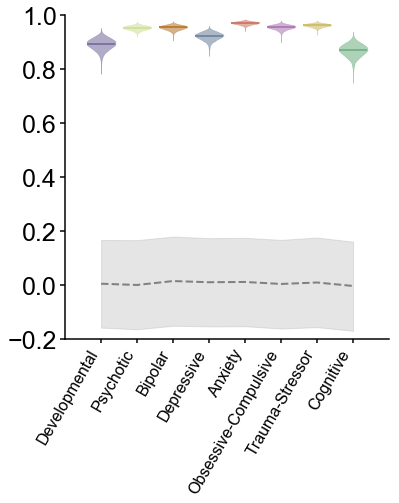

In [28]:
# Set up figure
fig = plt.figure(figsize=(4.5, 4.5))
ax = fig.add_axes([0,0,1,1])

# Null distributions as line plot
plt.plot(range(len(doms)), new_sim_df_null.mean(axis=1),
         "gray", linestyle="dashed", linewidth=2)
plt.fill_between(range(len(doms)), null_new_5, y2=null_new_95, 
                 color="gray", alpha=0.2)

# Bootstrap distributions as violin plots
for i, dom in enumerate(doms):
    for data, obs in [(new_sim_dom, new_sim_obs)]:
        data = sorted(data[i])
        v = ax.violinplot(data, positions=[i], 
                          showmeans=False, showmedians=False, widths=0.8)
        for pc in v["bodies"]:
            pc.set_facecolor(colors[i])
            pc.set_edgecolor(colors[i])
            pc.set_linewidth(0.5)
            pc.set_alpha(0.6)
        for line in ["cmaxes", "cmins", "cbars"]:
            v[line].set_edgecolor("none")
        plt.plot([i-0.35, i+0.35], [np.mean(obs[i]), np.mean(obs[i])], 
                 c=colors[i], alpha=1, lw=2)

# Set plot parameters
ax.set_xticks(range(len(doms)))
ax.set_xticklabels(dom_names, rotation=60, 
                   ha="right", fontproperties=prop_md)
plt.xticks(fontproperties=prop_md)
plt.yticks(fontproperties=prop_xlg)
ax.yaxis.set_label_coords(-0.35, 0.5)
plt.xlim([-1, len(doms)])
plt.ylim([-0.2, 1])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5, length=5)

# Export figure
plt.savefig("figures/dsm_seed_sim_class.png", dpi=250, bbox_inches="tight")
plt.show()

## Export results

In [29]:
columns = ["ORDER", "CLASS", "TOKEN", "SOURCE", "DISTANCE"]

def update_domain_sims(df, centroid, columns=columns):
    for i, dom in enumerate(doms):
        dom_centroid = centroid[i,:]
        tkns = df.loc[df["CLASS"] == dom, "TOKEN"]
        seed_tkns = list(seed_df.loc[
                         seed_df["CLASS"] == dom, "TOKEN"].values)
        for tkn in tkns:
            if tkn in vsm.index:
                dist = 1 - cosine(dom_centroid, vsm.loc[tkn])
                df.loc[(df["TOKEN"] == tkn) & 
                       (df["CLASS"] == dom), "DISTANCE"] = dist
            if tkn in seed_tkns:
                df.loc[(df["TOKEN"] == tkn) & 
                       (df["CLASS"] == dom), "SOURCE"] = "DSM"
            if tkn not in seed_tkns:
                df.loc[(df["TOKEN"] == tkn) & 
                       (df["CLASS"] == dom), "SOURCE"] = "Lexicon"
    df = df[columns]
    return df

In [30]:
new = update_domain_sims(new, seed_centroid)
new.to_csv("lists/lists_dsm_class_opsim.csv", index=None)
new.head()

,ORDER,CLASS,TOKEN,SOURCE,DISTANCE
0,1,DEVELOPMENTAL,attention_deficit_hyperactivity_disorder,Lexicon,0.688518
1,1,DEVELOPMENTAL,hyperactivity_disorder,Lexicon,0.647920
2,1,DEVELOPMENTAL,attention_deficithyperactivity_disorder,DSM,0.643591
3,1,DEVELOPMENTAL,autism_spectrum_disorder,DSM,0.636929
4,1,DEVELOPMENTAL,neurodevelopmental_disorder,DSM,0.628852


# 2. Construct word lists

## Generate lists across lengths

In [31]:
cons = list(OrderedDict.fromkeys(seed_df["CATEGORY"]))
seeds = list(seed_df["TOKEN"])
unique = [tkn for tkn in seeds if seeds.count(tkn) == 1]
len(unique)

584

In [32]:
def load_construct_lists(vsm, seed_df, n_thres=10, verbose=False):
    
    if verbose:
        print("Loading lists with n_thres={}".format(n_thres))
    
    lists = pd.DataFrame()
    for label in set(seed_df["CATEGORY"]):
        con_df = seed_df.loc[seed_df["CATEGORY"] == label]
        tokens = set(con_df["TOKEN"]).intersection(vsm.index)
        required = tokens.intersection(unique)
        forbidden = set(unique).difference(tokens)
        centroid = np.mean(vsm.loc[tokens]).values.reshape(1, -1)
        dists = cdist(vsm.loc[lexicon], centroid, metric="cosine")
        dists = pd.Series(dists.reshape(-1), index=lexicon).sort_values()
        dists = dists[dists < 0.5]
        dists = [(w, d) for w, d in dists.iteritems() 
                 if (w in required) or (w not in forbidden)][:n_thres]
        
        if verbose:
            if len(dists) == 0:
                print("No tokens assigned to {}".format(label))
        
        for w, d in dists:
            dic = {"ORDER": [list(con_df["ORDER"])[0] + 1],
                   "CLASS": [list(con_df["CLASS"])[0]],
                   "CATEGORY": [label],
                   "TOKEN": [w],
                   "SOURCE": ["DSM" if w in tokens else "Lexicon"],
                   "DISTANCE": [d]}
            lists = lists.append(pd.DataFrame(dic))
    
    lists = lists[["ORDER", "CLASS", "CATEGORY", "TOKEN", "SOURCE", "DISTANCE"]]
    lists = lists.sort_values(["ORDER", "DISTANCE"])
    return lists

In [33]:
list_len = 25
lists = load_construct_lists(vsm, seed_df, n_thres=list_len, verbose=True)
lists.to_csv("lists/lists_dsm_category.csv", index=None)

Loading lists with n_thres=25
No tokens assigned to LEARNING_DISORDER
No tokens assigned to INHALANT_RELATED_DISORDER
No tokens assigned to HALLUCINOGEN_RELATED_DISORDER
No tokens assigned to SEDATIVE_RELATED_DISORDER
No tokens assigned to PARAPHILIC_DISORDER


## Optimize length by similarity to seeds

In [34]:
lists = pd.read_csv("lists/lists_dsm_category.csv")

In [35]:
ops = []
df = pd.DataFrame(index=cons, columns=list_lens)
for con in cons:
    seed_tkns = seed_df.loc[seed_df["CATEGORY"] == con, "TOKEN"]
    seed_tkns = set(seed_tkns).intersection(vsm.index)
    seed_centroid = np.mean(vsm.loc[seed_tkns])
    for list_len in list_lens:
        len_tkns = lists.loc[lists["CATEGORY"] == con, "TOKEN"][:list_len]
        len_centroid = np.mean(vsm.loc[len_tkns])
        df.loc[con, list_len] = 1 - cosine(seed_centroid, len_centroid)
    sims = list(df.loc[con])
    idx = sims.index(max(sims))
    ops.append(np.array(list_lens)[idx])
df["OPTIMAL"] = ops
df.head()

,5,6,7,8,9,10,11,12,13,14,...,17,18,19,20,21,22,23,24,25,OPTIMAL
INTELLECTUAL_DISABILITY,0.882598,0.882598,0.882598,0.882598,0.882598,0.882598,0.882598,0.882598,0.882598,0.882598,...,0.882598,0.882598,0.882598,0.882598,0.882598,0.882598,0.882598,0.882598,0.882598,5
COMMUNICATION_DISORDER,0.863736,0.863736,0.863736,0.863736,0.863736,0.863736,0.863736,0.863736,0.863736,0.863736,...,0.863736,0.863736,0.863736,0.863736,0.863736,0.863736,0.863736,0.863736,0.863736,5
AUTISM,0.937336,0.941457,0.945877,0.933336,0.934387,0.935788,0.933522,0.937856,0.936504,0.933603,...,0.933603,0.933603,0.933603,0.933603,0.933603,0.933603,0.933603,0.933603,0.933603,7
ADHD,0.96479,0.976934,0.970214,0.984982,0.982259,0.976174,0.972305,0.971657,0.969351,0.967169,...,0.967169,0.967169,0.967169,0.967169,0.967169,0.967169,0.967169,0.967169,0.967169,8
LEARNING_DISORDER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [36]:
new = pd.DataFrame(columns=["ORDER", "CLASS", "CATEGORY", "TOKEN", 
                            "SOURCE", "DISTANCE"])
for order, con in enumerate(cons):
    list_len = df.loc[con, "OPTIMAL"]
    new = new.append(lists.loc[lists["CATEGORY"] == con][:list_len])
new.head()

,ORDER,CLASS,CATEGORY,TOKEN,SOURCE,DISTANCE
0,1,DEVELOPMENTAL,INTELLECTUAL_DISABILITY,global_developmental_delay,DSM,0.315223
1,1,DEVELOPMENTAL,INTELLECTUAL_DISABILITY,intellectual_disability,DSM,0.349480
2,1,DEVELOPMENTAL,INTELLECTUAL_DISABILITY,borderline_intellectual_functioning,DSM,0.370608
3,2,DEVELOPMENTAL,COMMUNICATION_DISORDER,speech_sound_disorder,DSM,0.385449
4,2,DEVELOPMENTAL,COMMUNICATION_DISORDER,social_communication_disorder,DSM,0.430533


## Filter by word occurrences

In [37]:
filt_cons = []
for con in OrderedDict.fromkeys(new["CATEGORY"]):
    tkns = set(new.loc[new["CATEGORY"] == con, "TOKEN"]).intersection(dtm.columns)
    dom = new.loc[new["CATEGORY"] == con, "CLASS"].values[0]
    freq = dtm_bin[tkns].sum().sum() / float(len(dtm))
    if (dom in filt_doms) and (freq > 0.005):
        print("{:25s} {:6.4f}".format(con, freq))
        filt_cons.append(con)
cons = filt_cons

INTELLECTUAL_DISABILITY   0.0064
COMMUNICATION_DISORDER    0.0102
AUTISM                    0.6773
ADHD                      0.1818
NEURODEV_DISORDER         0.1329
PSYCHOTIC_DISORDER        0.0706
CATATONIA                 0.0060
BIPOLAR_DISORDER          0.1986
DEPRESSIVE_DISORDER       1.2075
ANXIETY_DISORDER          0.2765
OCD                       0.1076
TRAUMATIC_DISORDER        0.1571
NEUROCOGNITIVE_DISORDER   0.1620


In [38]:
new = new.loc[new["CATEGORY"].isin(filt_cons)]
new = new.loc[new["DISTANCE"] > 0]
print("Categories after filtering: N={}".format(len(set(new["CATEGORY"]))))

Categories after filtering: N=13


In [39]:
df.to_csv("lists/df_dsm_category_opsim.csv")
new.to_csv("lists/lists_dsm_category_opsim.csv", index=None)

## Plot similarity to seeds

### Centroids

In [40]:
seed_centroid = compute_centroid(seed_df, level="CATEGORY", labels=cons)
new_centroid = compute_centroid(new, level="CATEGORY", labels=cons)

### Bootstrap distribution

In [41]:
n_iter = 10000
new_sim = []
for n in range(n_iter):
    new_sim.append(compute_sims_sample(new_centroid, seed_centroid))
new_sim_con = [[1-new_sim[j][i] for j in range(n_iter)] for i in range(len(cons))]
new_sim_df = pd.DataFrame(new_sim_con, index=cons)

### Null distributions

In [42]:
n_iter = 10000
new_sim = []
for n in range(n_iter):
    new_sim.append(compute_sims_shuffle(new_centroid, seed_centroid))
new_sim_null = [[1-new_sim[j][i] for j in range(n_iter)] for i in range(len(cons))]
new_sim_df_null = pd.DataFrame(new_sim_null, index=cons)

### Observed values

In [43]:
seed_centroid = compute_centroid(seed_df, level="CATEGORY", labels=cons)
new_sim_obs = [1.0-s for s in compute_sims(new, seed_centroid, level="CATEGORY", labels=cons)]

### Comparison tests

Is similarity to RDoC seed centroids higher for new vs. null models?

In [44]:
p_vals = []
for i, con in enumerate(cons):
    difs = sorted(np.array(new_sim_con[i]) - np.array(new_sim_null[i]))
    count = sum(np.greater(difs, 0))
    p_vals.append(1-(count/n_iter))
p_cor_null_new = fdrcorrection(p_vals)[1]
report_no_dif(p_cor_null_new, cons)

### Confidence intervals

In [45]:
null_new_5, null_new_95 = [], []
for con in cons:
    idx_5 = int(n_iter * 0.05)
    idx_95 = int(n_iter * 0.95)
    null = sorted(list(new_sim_df_null.loc[con]))
    null_new_5.append(null[idx_5])
    null_new_95.append(null[idx_95])

## Plot results

Comparison of new method vs. method of McCoy *et al.* in terms of similarity between the synonyms and RDoC seed terms. Statistics based on bootstrapping and permutation testing.

In [46]:
con_names = [con.replace("_", " ").title().replace("Ocd", "OCD").replace("Adhd", "ADHD").replace("Neurodev", "Neurodevelopmental") for con in cons]
dom_colors = ["#BA7E39", # Orange
              "#D1E29E", # Chartreuse
              "#B07EB6", # Magenta
              "#778AA3", # Blue
              "#CE7D69", # Red
              "#7D74A3", # Purple
              "#CEBE6D", # Yellow
              "#77B58A"] # Green
con_colors = ["#BA7E39"] * 5 + ["#D1E29E"] * 2 + ["#B07EB6", "#778AA3", "#CE7D69", "#7D74A3", "#CEBE6D", "#77B58A"]

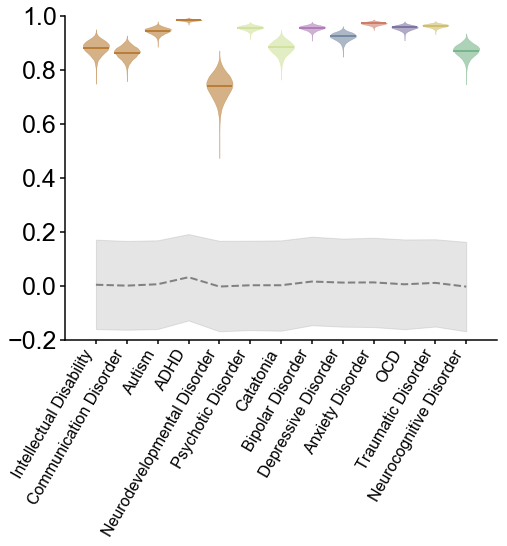

In [47]:
# Set up figure
fig = plt.figure(figsize=(6, 4.5))
ax = fig.add_axes([0,0,1,1])

# Null distributions as line plots
plt.plot(range(len(cons)), new_sim_df_null.mean(axis=1),
         "gray", linestyle="dashed", linewidth=2)
plt.fill_between(range(len(cons)), null_new_5, y2=null_new_95, 
                 color="gray", alpha=0.2)

# Bootstrap distributions as violin plots
for i, con in enumerate(cons):
    for data, obs, color in [(new_sim_con, new_sim_obs, con_colors[i])]:
        data = sorted(data[i])
        v = ax.violinplot(data, positions=[i], 
                          showmeans=False, showmedians=False, widths=0.85)
        for pc in v["bodies"]:
            pc.set_facecolor(color)
            pc.set_edgecolor(color)
            pc.set_linewidth(0.5)
            pc.set_alpha(0.6)
        for line in ["cmaxes", "cmins", "cbars"]:
            v[line].set_edgecolor("none")
        plt.plot([i-0.38, i+0.38], [np.mean(obs[i]), np.mean(obs[i])], 
                 c=color, alpha=1, lw=2)

# Set plot parameters
ax.set_xticks(range(len(cons)))
ax.set_xticklabels(con_names, rotation=60, 
                   ha="right", fontproperties=prop_md)
plt.xticks(fontproperties=prop_md)
plt.yticks(fontproperties=prop_xlg)
plt.xlim([-1, len(cons)])
plt.ylim([-0.2, 1])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5, length=5)

# Export figure
plt.savefig("figures/dsm_seed_sim_categories.png", 
            dpi=250, bbox_inches="tight")
plt.show()

## Export results

In [48]:
columns = ["ORDER", "CLASS", "CATEGORY", "TOKEN", "SOURCE", "DISTANCE"]

def update_construct_sims(df, centroid, columns=columns):
    for i, con in enumerate(cons):
        con_centroid = centroid[i,:]
        tkns = df.loc[df["CATEGORY"] == con, "TOKEN"]
        seed_tkns = list(seed_df.loc[
                        seed_df["CATEGORY"] == con, "TOKEN"].values)
        for tkn in tkns:
            if tkn in vsm.index:
                dist = 1 - cosine(con_centroid, vsm.loc[tkn])
                df.loc[(df["TOKEN"] == tkn) & 
                       (df["CATEGORY"] == con), "DISTANCE"] = dist
            if tkn in seed_tkns:
                df.loc[(df["TOKEN"] == tkn) & 
                       (df["CATEGORY"] == con), "SOURCE"] = "DSM"
            if tkn not in seed_tkns:
                df.loc[(df["TOKEN"] == tkn) & 
                       (df["CATEGORY"] == con), "SOURCE"] = "Lexicon"
    df = df[columns]
    return df

In [49]:
seeds = update_construct_sims(seed_df, seed_centroid)
new = update_construct_sims(new, seed_centroid)
new.head()

,ORDER,CLASS,CATEGORY,TOKEN,SOURCE,DISTANCE
0,1,DEVELOPMENTAL,INTELLECTUAL_DISABILITY,global_developmental_delay,DSM,0.684777
1,1,DEVELOPMENTAL,INTELLECTUAL_DISABILITY,intellectual_disability,DSM,0.650520
2,1,DEVELOPMENTAL,INTELLECTUAL_DISABILITY,borderline_intellectual_functioning,DSM,0.629392
3,2,DEVELOPMENTAL,COMMUNICATION_DISORDER,speech_sound_disorder,DSM,0.614551
4,2,DEVELOPMENTAL,COMMUNICATION_DISORDER,social_communication_disorder,DSM,0.569467


In [50]:
new.to_csv("lists/lists_dsm_category_opsim.csv", index=None)
seeds.to_csv("lists/lists_dsm_category_seeds.csv", index=None)

# Visualize the circuits

In [51]:
for category in [UserWarning, DeprecationWarning]:
    warnings.simplefilter(action="ignore", category=category)

## Compute PPMI-weighted links

In [52]:
from statsmodels.stats import multitest

In [53]:
atlas_labels = pd.read_csv("../data/atlases/harvard-oxford.csv")
act_bin = pd.read_csv("../data/dcm_0mm_thres0.csv", index_col=0) # Previously binarized
act_bin = act_bin[atlas_labels["PREPROCESSED"]]

In [54]:
dtm_bin = np.empty((dtm.shape[0], dtm.shape[1]))
for i, (word, mean_docfreq) in enumerate(dtm.mean().iteritems()):
    dtm_bin[:,i] = 1 * (dtm[word] > mean_docfreq)
dtm_bin = pd.DataFrame(dtm_bin, index=dtm.index, columns=dtm.columns)

In [55]:
dom_lists = pd.read_csv("lists/lists_dsm_class_opsim.csv")
con_lists = pd.read_csv("lists/lists_dsm_category_opsim.csv")

In [56]:
def mean_thres(df):
    col_mean = df.mean()
    df_bin = np.empty((df.shape[0], df.shape[1]))
    i = 0
    for col, doc_mean in col_mean.iteritems():
        df_bin[:,i] = 1 * (df[col] > doc_mean)
        i += 1
    df_bin = pd.DataFrame(df_bin, columns=df.columns, index=df.index)
    return df_bin

In [57]:
def score_lists(lists, dtm, label_var="LABEL"):
    labels = OrderedDict.fromkeys(lists[label_var])
    list_counts = pd.DataFrame(index=dtm.index, columns=labels)
    for label in list_counts.columns:
        tkns = lists.loc[lists[label_var] == label, "TOKEN"]
        tkns = [token for token in tkns if token in dtm.columns]
        list_counts[label] = dtm[tkns].sum(axis=1)
    list_scores = mean_thres(list_counts)
    return list_scores

In [58]:
dom_scores = score_lists(dom_lists, dtm_bin, label_var="CLASS")
con_scores = score_lists(con_lists, dtm_bin, label_var="CATEGORY")

In [59]:
pmids = act_bin.index.intersection(dom_scores.index)
len(pmids)

18155

In [60]:
act_bin = act_bin.loc[pmids]
dom_scores = dom_scores.loc[pmids]

In [61]:
def observed_over_expected(X):
    col_totals = np.sum(X, axis=0)
    total = col_totals.sum()
    row_totals = np.sum(X, axis=1)
    expected = np.outer(row_totals, col_totals) / total
    oe = X / expected
    return oe

def pmi(X, positive=True):
    X = observed_over_expected(X)
    with np.errstate(divide="ignore"):
        X = np.log(X)
    X[np.isinf(X)] = 0.0  # log(0) = 0
    if positive:
        X[X < 0] = 0.0
    return X

def compute_cooccurrences(activations, scores):
    X = np.matmul(activations.values.T, scores.values)
    X = pmi(X, positive=True)
    X = pd.DataFrame(X, columns=scores.columns, index=activations.columns)
    X = X.dropna(axis=1, how="any")
    X = X.loc[:, (X != 0).any(axis=0)]
    return X

def compute_cooccurrences_null(activations, scores, n_iter=1000, verbose=False):
    np.random.seed(42)
    X_null = np.empty((activations.shape[1], scores.shape[1], n_iter))
    act_mat = activations.values.T
    scores_mat = scores.values
    n_docs = len(scores)
    for n in range(n_iter):
        null = np.random.choice(range(n_docs), size=n_docs, replace=False)
        X = np.matmul(act_mat, scores_mat[null,:])
        X = pmi(X, positive=True)
        X_null[:,:,n] = X
        if verbose:
            if n % (n_iter/10) == 0:
                print("Iteration {}".format(n))
    return X_null

In [62]:
dom_links = compute_cooccurrences(act_bin, dom_scores)

In [63]:
n_iter = 10000
dom_links_null = compute_cooccurrences_null(act_bin, dom_scores, n_iter=n_iter, verbose=True)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


In [64]:
p = pd.DataFrame(index=act_bin.columns, columns=dom_scores.columns)
for i, struct in enumerate(act_bin.columns):
    for j, dom in enumerate(dom_scores.columns):
        obs = dom_links.values[i,j]
        null = dom_links_null[i,j,:]
        p.loc[struct, dom] = np.sum(null > obs) / float(n_iter)

In [65]:
p_cor = multitest.multipletests(p.values.ravel(), method="fdr_bh")[1]
p_cor = pd.DataFrame(p_cor.reshape(p.shape), index=act_bin.columns, columns=dom_scores.columns)

In [66]:
dom_links_thres = dom_links[p_cor < 0.01]
dom_links_thres = dom_links_thres.fillna(0.0)

In [67]:
dom_links_thres.to_csv("circuits/circuits_domain_dsm.csv")

## Map PPMI-weighted links

In [73]:
for category in [FutureWarning, UserWarning]:
    warnings.simplefilter(action="ignore", category=category)

In [74]:
def load_atlas():

    cer = "../data/atlases/Cerebellum-MNIfnirt-maxprob-thr0-1mm.nii.gz"
    cor = "../data/atlases/HarvardOxford-cort-maxprob-thr25-1mm.nii.gz"
    sub = "../data/atlases/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz"

    bilateral_labels = pd.read_csv("../data/atlases/harvard-oxford_orig.csv", index_col=0, header=0)

    sub_del_dic = {1:0, 2:0, 3:0, 12:0, 13:0, 14:0}
    sub_lab_dic_L = {4:1, 5:2, 6:3, 7:4, 9:5, 10:6, 11:7, 8:8}
    sub_lab_dic_R = {15:1, 16:2, 17:3, 18:4, 19:5, 20:6, 21:7, 7:8}

    sub_mat_L = image.load_img(sub).get_data()[91:,:,:]
    sub_mat_R = image.load_img(sub).get_data()[:91,:,:]

    for old, new in sub_del_dic.items():
        sub_mat_L[sub_mat_L == old] = new
    for old, new in sub_lab_dic_L.items():
        sub_mat_L[sub_mat_L == old] = new
    sub_mat_L = sub_mat_L + 48
    sub_mat_L[sub_mat_L == 48] = 0

    for old, new in sub_del_dic.items():
        sub_mat_R[sub_mat_R == old] = new
    for old, new in sub_lab_dic_R.items():
        sub_mat_R[sub_mat_R == old] = new
    sub_mat_R = sub_mat_R + 48
    sub_mat_R[sub_mat_R == 48] = 0

    cor_mat_L = image.load_img(cor).get_data()[91:,:,:]
    cor_mat_R = image.load_img(cor).get_data()[:91,:,:]

    mat_L = np.add(sub_mat_L, cor_mat_L)
    mat_L[mat_L > 56] = 0
    mat_R = np.add(sub_mat_R, cor_mat_R)
    mat_R[mat_R > 56] = 0

    mat_R = mat_R + 57
    mat_R[mat_R > 113] = 0
    mat_R[mat_R < 58] = 0

    cer_mat_L = image.load_img(cer).get_data()[91:,:,:]
    cer_mat_R = image.load_img(cer).get_data()[:91,:,:]
    cer_mat_L[cer_mat_L > 0] = 57
    cer_mat_R[cer_mat_R > 0] = 114

    mat_L = np.add(mat_L, cer_mat_L)
    mat_L[mat_L > 57] = 0
    mat_R = np.add(mat_R, cer_mat_R)
    mat_R[mat_R > 114] = 0

    mat = np.concatenate((mat_R, mat_L), axis=0)
    atlas_image = image.new_img_like(sub, mat)

    return atlas_image

In [75]:
def map_plane(estimates, path, suffix="", plane="z", c=None, cbar=False, annotate=False,
              vmin=None, vmax=None, cmaps=[], print_fig=True, verbose=False):
    atlas = load_atlas()
    for f, feature in enumerate(estimates.columns):
        stat_map = image.copy_img(atlas).get_data()
        data = estimates[feature]
        if verbose:
            print("{:20s} Min: {:6.4f}  Mean: {:6.4f}  Max: {:6.4f}".format(
                  feature, min(data), np.mean(data), max(data)))
        if not verbose and print_fig:
            print("\n{}".format(feature))
        for i, value in enumerate(data):
            stat_map[stat_map == i+1] = value
        stat_map = image.new_img_like(atlas, stat_map)
        display = plotting.plot_stat_map(stat_map,
                                         display_mode=plane, cut_coords=c,
                                         symmetric_cbar=False, colorbar=cbar,
                                         cmap=cmaps[f], threshold=vmin, 
                                         vmax=vmax, alpha=0.65,
                                         annotate=annotate, draw_cross=False)
        file_name = "{}/{}{}.png".format(path, feature, suffix)
        display.savefig(file_name, dpi=250)
        img = Image.open(file_name)
        img = img.convert("RGBA")
        data = img.getdata()
        newData = []
        for item in data:
            if item[0] == 255 and item[1] == 255 and item[2] == 255:
                newData.append((255, 255, 255, 0))
            else:
                newData.append(item)
        img.putdata(newData)
        img.save(file_name, "PNG")
        if print_fig:
            plotting.show()
        display.close()

In [76]:
purples = make_cmap([(1,1,1), (0.365,0,0.878)])
chartreuses = make_cmap([(1,1,1), (0.345,0.769,0)])
magentas = make_cmap([(1,1,1), (0.620,0,0.686)])
yellows = make_cmap([(1,1,1), (0.937,0.749,0)])
dom_cmaps = [purples, chartreuses, "Oranges", 
             "Blues", "Reds", magentas, yellows, "Greens"]

DEVELOPMENTAL        Min: 0.0000  Mean: 0.0256  Max: 0.1775


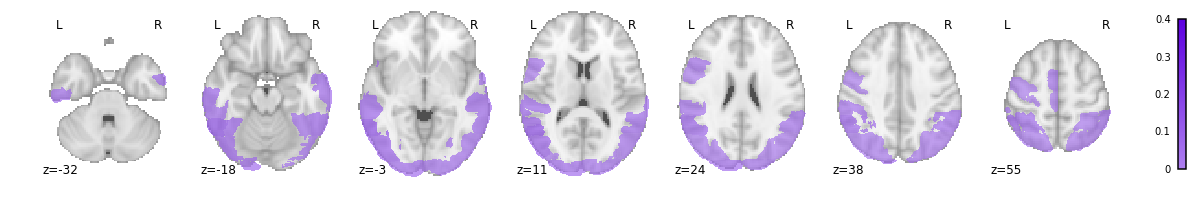

PSYCHOTIC            Min: 0.0000  Mean: 0.0005  Max: 0.0591


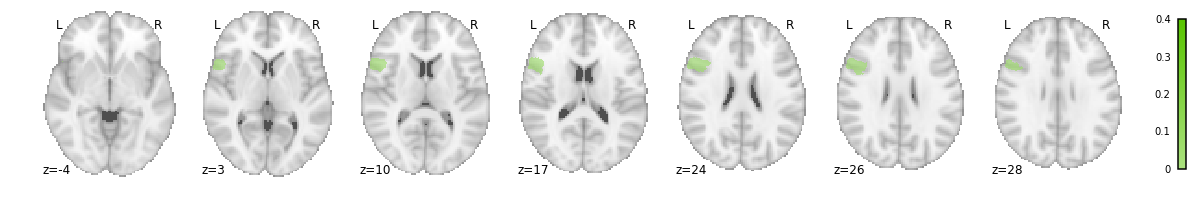

BIPOLAR              Min: 0.0000  Mean: 0.0021  Max: 0.1198


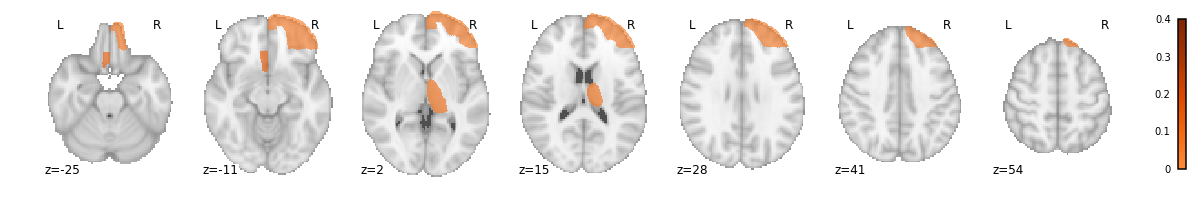

DEPRESSIVE           Min: 0.0000  Mean: 0.0158  Max: 0.1364


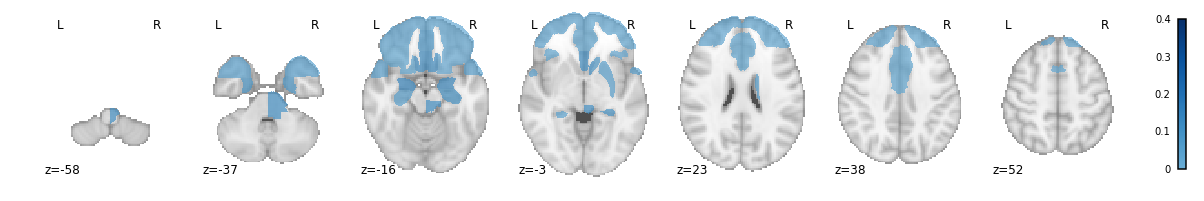

ANXIETY              Min: 0.0000  Mean: 0.0168  Max: 0.3054


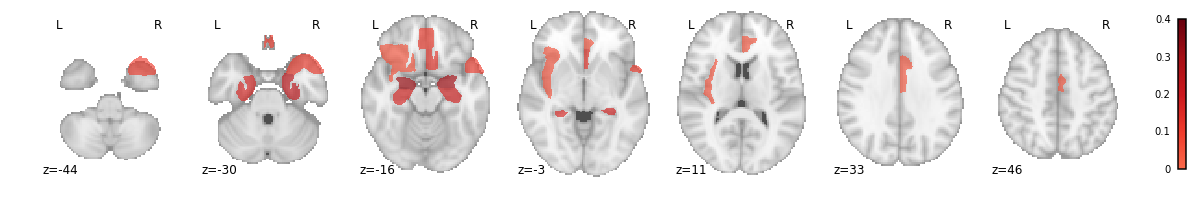

OBSESSIVE_COMPULSIVE Min: 0.0000  Mean: 0.0117  Max: 0.2405


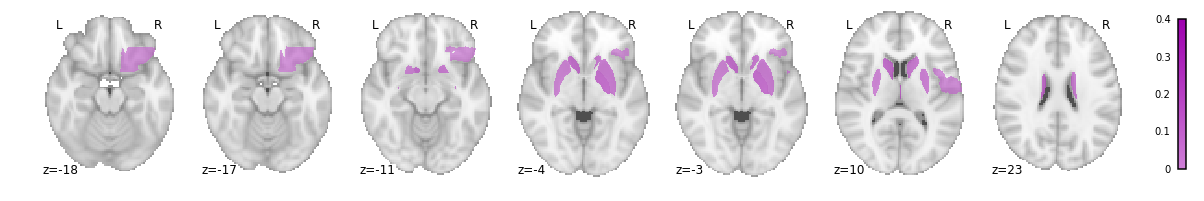

TRAUMA_STRESSOR      Min: 0.0000  Mean: 0.0212  Max: 0.3682


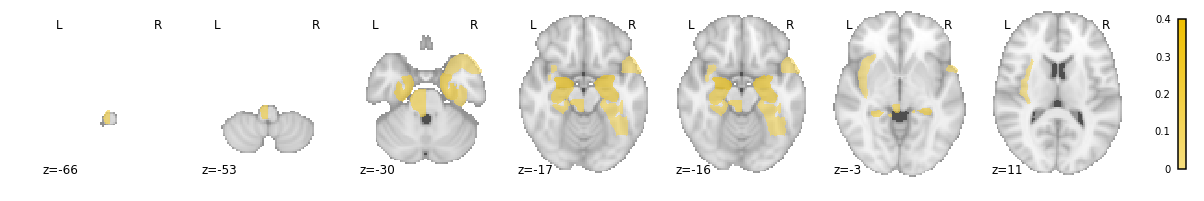

COGNITIVE            Min: 0.0000  Mean: 0.0146  Max: 0.1386


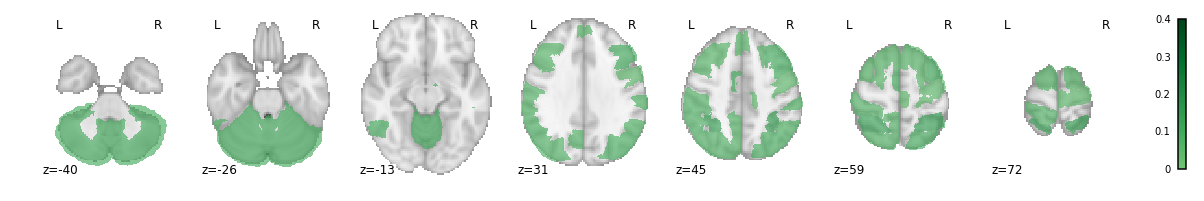

In [85]:
map_plane(dom_links_thres, "figures/circuits/dsm/ppmi_domain", suffix="_z", 
          cmaps=dom_cmaps, plane="z", cbar=True, vmin=0.0, vmax=0.4,
          verbose=True, print_fig=True, annotate=True)

In [79]:
for plane in ["x", "y"]:
    map_plane(dom_links_thres, "figures/circuits/dsm/ppmi_domain", suffix="_{}".format(plane), 
              cmaps=dom_cmaps, plane=plane, cbar=True, vmin=0.0, vmax=0.4,
              verbose=False, print_fig=False, annotate=True)

## Compute correlations

In [80]:
from scipy.stats import pointbiserialr
for category in [UserWarning, DeprecationWarning]:
    warnings.simplefilter(action="ignore", category=category)

In [81]:
def score_lists_norm(lists, dtm, label_var="LABEL"):
    labels = OrderedDict.fromkeys(lists[label_var])
    list_counts = pd.DataFrame(index=dtm.index, columns=labels)
    for label in list_counts.columns:
        tkns = lists.loc[lists[label_var] == label, "TOKEN"]
        tkns = [token for token in tkns if token in dtm.columns]
        list_counts[label] = dtm[tkns].sum(axis=1)
    list_scores = list_counts / np.sum(list_counts, axis=0)
    return list_scores

In [82]:
dom_scores_norm = score_lists_norm(dom_lists, dtm_bin, label_var="CLASS")

In [83]:
dom_cors = pd.DataFrame(0.0, index=act_bin.columns, columns=doms)
for struct in act_bin.columns:
    for dom in doms:
        r, p = pointbiserialr(act_bin.loc[pmids,struct], dom_scores_norm.loc[pmids,dom])
        if r > 0 and p < 0.1:
            dom_cors.loc[struct, dom] = r

## Map correlations

DEVELOPMENTAL        Min: 0.0000  Mean: 0.0012  Max: 0.0207


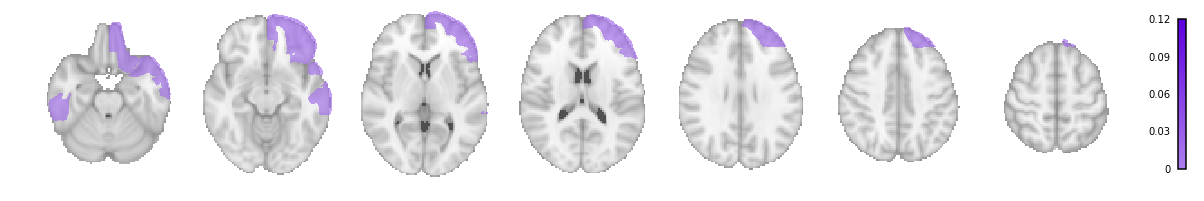

PSYCHOTIC            Min: 0.0000  Mean: 0.0002  Max: 0.0139


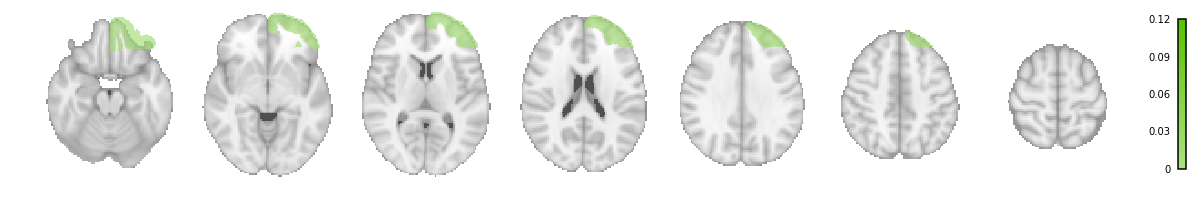

BIPOLAR              Min: 0.0000  Mean: 0.0018  Max: 0.0342


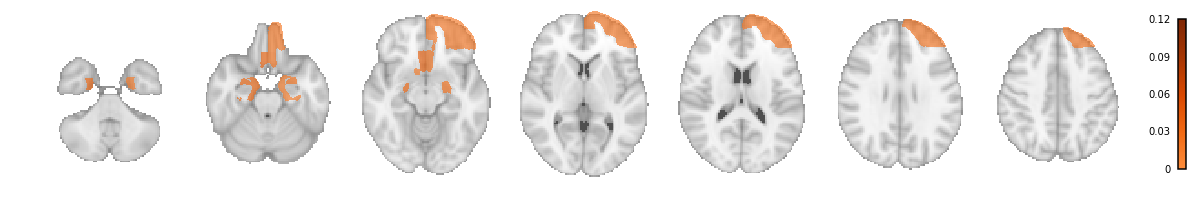

DEPRESSIVE           Min: 0.0000  Mean: 0.0055  Max: 0.0727


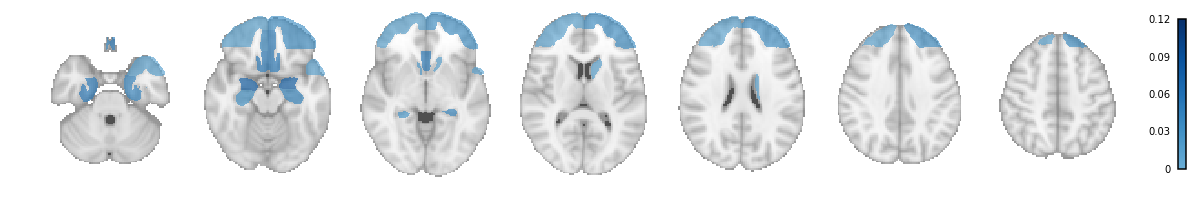

ANXIETY              Min: 0.0000  Mean: 0.0067  Max: 0.1191


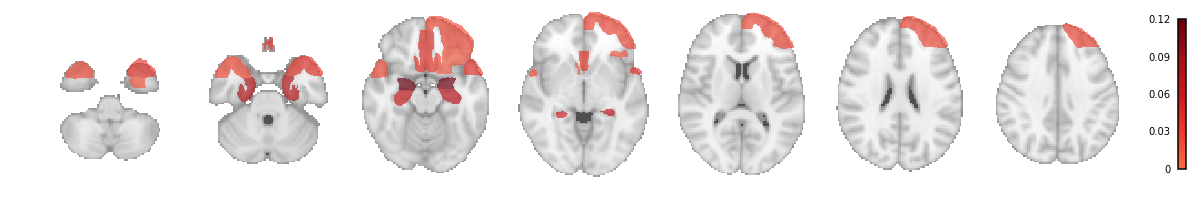

OBSESSIVE_COMPULSIVE Min: 0.0000  Mean: 0.0036  Max: 0.0385


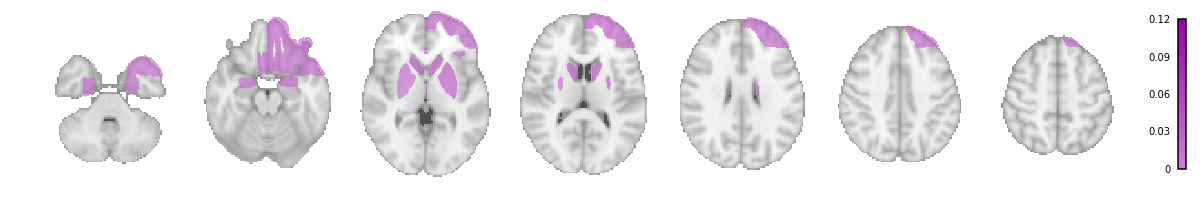

TRAUMA_STRESSOR      Min: 0.0000  Mean: 0.0069  Max: 0.1122


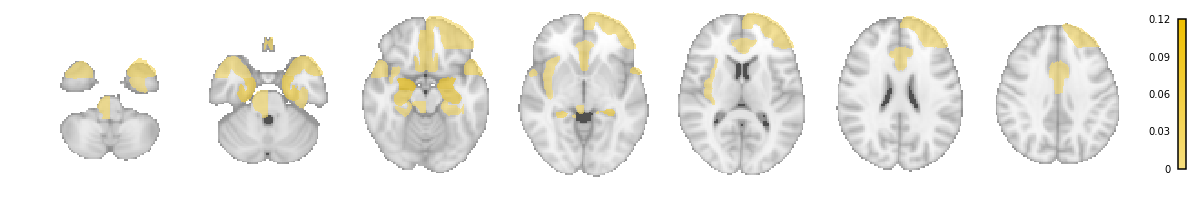

COGNITIVE            Min: 0.0000  Mean: 0.0007  Max: 0.0220


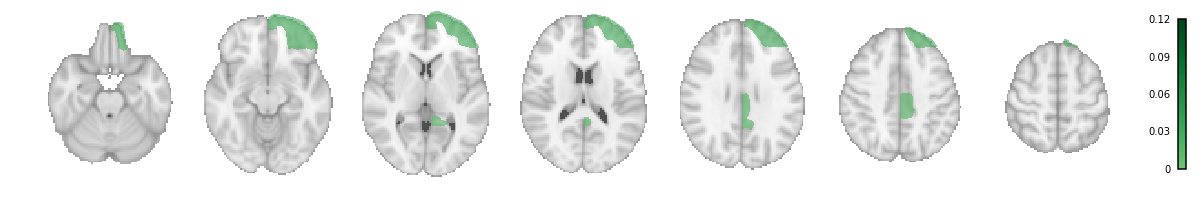

In [84]:
map_plane(dom_cors, "figures/circuits/dsm/cor_domain", suffix="_z", 
          cmaps=dom_cmaps, plane="z", cbar=True, vmin=0.0, vmax=0.12,
          verbose=True, print_fig=True, annotate=False)
for plane in ["x", "y"]:
    map_plane(dom_cors, "figures/circuits/dsm/cor_domain", suffix="_{}".format(plane), 
              cmaps=dom_cmaps, plane=plane, cbar=True, vmin=0.0, vmax=0.12,
              verbose=False, print_fig=False, annotate=False)